# Loading data

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json   

In [4]:
! kaggle datasets download jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:35<00:00, 38.5MB/s]
100% 1.33G/1.33G [00:35<00:00, 40.5MB/s]


In [5]:
! unzip celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from keras import preprocessing
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout 
from numpy import asarray,linspace,mean,expand_dims,savez_compressed,load,vstack,load,zeros,ones
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential,load_model
from numpy.random import randn,randint
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd 
import os
import warnings
warnings.filterwarnings('ignore')

In [7]:
path_celeb = []
train_path_celeb ="/content/img_align_celeba/img_align_celeba/"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [8]:
#selecting subset of data for training
new_path=path_celeb[0:60000]

In [9]:
crop = (30, 55, 150, 175)
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    
images = np.array(images) 

In [10]:
X_train=images

<Figure size 720x720 with 0 Axes>

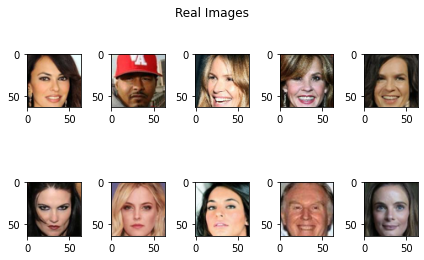

In [11]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
        ax[i,j].imshow(X_train[idx].reshape(64,64,3))
        idx+=600
            
plt.tight_layout()
plt.show()

# Model
This below cell represent the discriminator, generator and GAN models. Display the output of training.

## Generator
  > Generator as name represent it generate synthetic data.
  It work as an artist which tries to generate an images

## Discriminator
  > Discriminator tries to distinguish between real and fake images.
  It work as art critice who tries to identify among images which one is fake and which one is real one
  
## Generative Adversarial Network 
  >GAN is composed of two neural networks called the generator and discriminator, which keep pitting against each other

In [27]:
#defining latent
noise = 60
#defining discriminator model
def discriminator(in_shape=(64,64,3)):
    disc = Sequential()
    disc.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    disc.add(LeakyReLU(alpha=0.2))
    disc.add(Flatten())
    disc.add(Dropout(0.4))
    disc.add(Dense(1, activation='sigmoid'))
    opt = Adam(lr=0.0002, beta_1=0.5)
    disc.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return disc

#defining generator model
def generator(noise):
    gen=Sequential()
    gen.add(Dense(4*4*512,input_shape=[noise]))
    gen.add(Reshape([4,4,512]))
    gen.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())
    gen.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())
    gen.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(BatchNormalization())
    gen.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",activation='sigmoid'))
    return gen

#defining complete model
def gan(generator_model, discriminator_model):
    discriminator_model.trainable = False
    model = Sequential([generator_model,discriminator_model])
    model.compile(optimizer='adam',loss='binary_crossentropy')
    return model

#loading scaled training data
def load_real_samples():
    data = X_train
    return data

#returing random sample and  their label
def generate_real_samples(df, n_samples):
    ix = randint(0, df.shape[0], n_samples)
    X = df[ix]
    y = ones((n_samples, 1))
    return X, y

#generating batch of input sample for generator model
def generate_latent_points(noise, n_samples):
    x_input = randn(noise * n_samples)
    x_input = x_input.reshape(n_samples, noise)
    return x_input

#generating fake images and returing their labels
def generate_fake_samples(generator_model, noise, n_samples):
    x_input = generate_latent_points(noise, n_samples)
    X = generator_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

#saving generated images
def save_plot(samples, epoch, n=10):
    examples = (samples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(samples[i],interpolation='nearest')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

#evaluating performance of discriminator on real and fake data
def model_performance(epoch, generator_model, discriminator_modeldiscriminator_model, df, noise, n_samples=100):
    X_real, y_real = generate_real_samples(df, n_samples)
    _, acc_real = discriminator_modeldiscriminator_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(generator_model, noise, n_samples)
    _, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)
    print(' > Accuracy Real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch+1)
    generator_model.save(filename)

#training model
def model_train(generator_model, discriminator_model, gan_model, df, noise, n_epochs=100, n_batch=128):
    bat_per_epo = int(df.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(df, half_batch)
            d_loss1, _ = discriminator_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(generator_model, noise, half_batch)
            d_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(noise, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('epoc:%d,batch per epoch: %d/%d, d1 loss=%.3f, d2 loss=%.3f g loss=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i+1) % 10 == 0:
            model_performance(i, generator_model, discriminator_model, df, noise)

discriminator_model = discriminator()
generator_model = generator(noise)
gan_model = gan(generator_model, discriminator_model)
df = load_real_samples()
model_train(generator_model, discriminator_model, gan_model, df, noise)

Streaming output truncated to the last 5000 lines.
epoc:90,batch per epoch: 153/468, d1 loss=0.071, d2 loss=0.122 g loss=5.651
epoc:90,batch per epoch: 154/468, d1 loss=0.064, d2 loss=0.048 g loss=6.430
epoc:90,batch per epoch: 155/468, d1 loss=0.076, d2 loss=0.023 g loss=5.827
epoc:90,batch per epoch: 156/468, d1 loss=0.060, d2 loss=0.117 g loss=6.867
epoc:90,batch per epoch: 157/468, d1 loss=0.075, d2 loss=0.031 g loss=6.478
epoc:90,batch per epoch: 158/468, d1 loss=0.079, d2 loss=0.070 g loss=6.795
epoc:90,batch per epoch: 159/468, d1 loss=0.163, d2 loss=0.134 g loss=6.106
epoc:90,batch per epoch: 160/468, d1 loss=0.156, d2 loss=0.158 g loss=7.327
epoc:90,batch per epoch: 161/468, d1 loss=0.111, d2 loss=0.008 g loss=6.497
epoc:90,batch per epoch: 162/468, d1 loss=0.013, d2 loss=0.024 g loss=6.334
epoc:90,batch per epoch: 163/468, d1 loss=0.041, d2 loss=0.072 g loss=6.610
epoc:90,batch per epoch: 164/468, d1 loss=0.027, d2 loss=0.020 g loss=6.563
epoc:90,batch per epoch: 165/468, d1 

## Interpolation between generated faces
  >If I have to describe latent space in one sentence, it simply means a representation of compressed data. (Ekin Tiu)
  
We defined a function to generate images by using our model. Two random samples are created in 100 dimensional space by using the defined function and feed to our model as an input. Which calculate the interpolation path between the two points in latent space and generate images whcih are later plotted.
<br>

we have performed a linear interpolation which assumes that the latent space is uniformly distributed hypercube. Technically, our chosen latent space is a 100-dimension hypersphere or multimodal Gaussian distribution.
<br>

The linear interpolation is performed between two points in the latent space by *interpolate_points* function which returns the interpolated vectors between two points in the latent space.


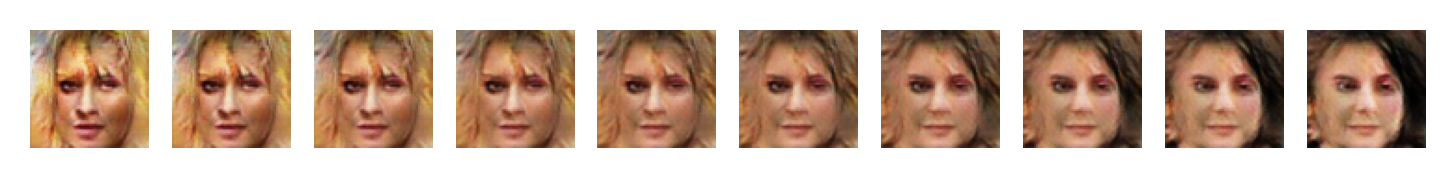

In [68]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    ratios = linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.show()

model = load_model('generator_model_030.h5')
pts = generate_latent_points(60, 2)
interpolated = interpolate_points(pts[0], pts[1])
X = model.predict(interpolated)
plot_generated(X, len(interpolated))

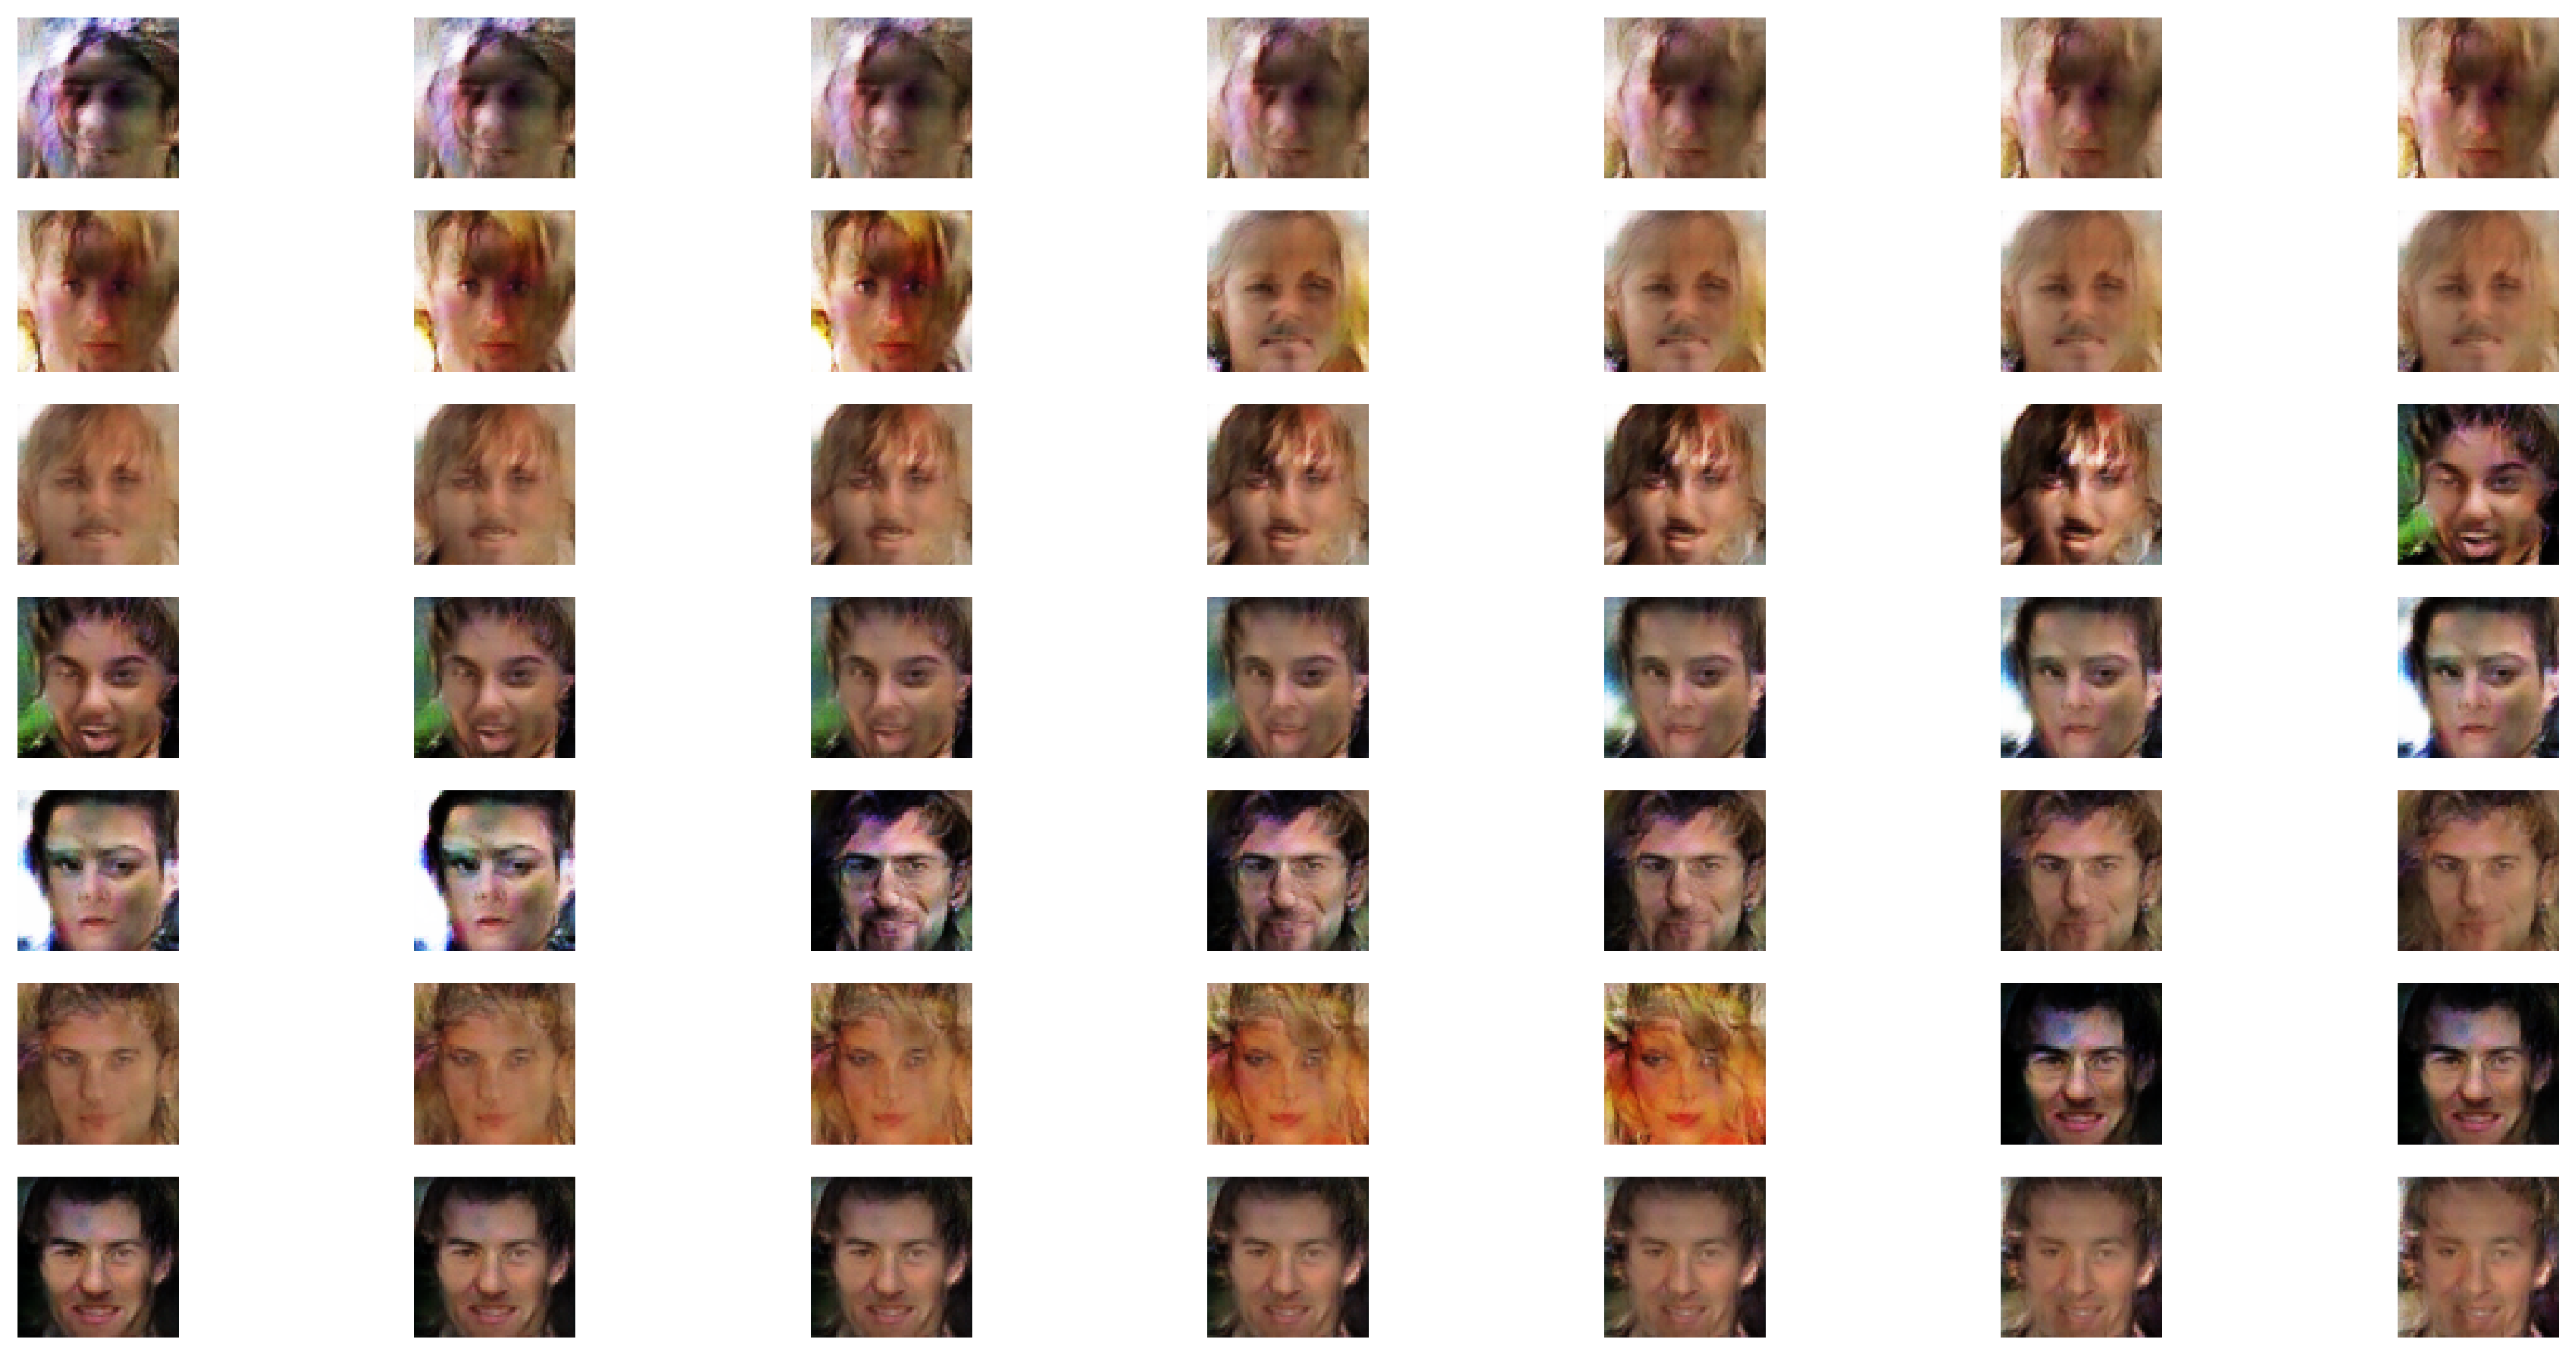

In [38]:
def plot_generated(sample, n):
    plt.figure(figsize=(20,10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(sample[i, :, :])
    plt.show()

model = load_model('/content/generator_model_050.h5')
# model.compile(loss='binary_crossentropy', optimizer='Adam')
n = 10
pts = generate_latent_points(60, n)
results = None
for i in range(0, n, 2):
    interpolated_points = interpolate_points(pts[i], pts[i+1])
    X = model.predict(interpolated_points)
    # X = (X + 1) / 2.0
    if results is None:
        results = X
    else:
        results = vstack((results, X))
# plot the result
plot_generated(results, 7)

# Vector Arithmetic
These vector characteristics allow us to easy manipulate the semantic qualities of many generated samples using arithmetic operations. Therefore we consider the noise after looking into the output images and try to do simple operations with them. Experiments have shown that the average of at least images is needed to get reasonable results. As demonstrated in the image, the calculation of vector(“smiling female”) - vector(“neutral female”) + vector(“neutral male”) produces a vector(“smiling Man”) after running the generator.

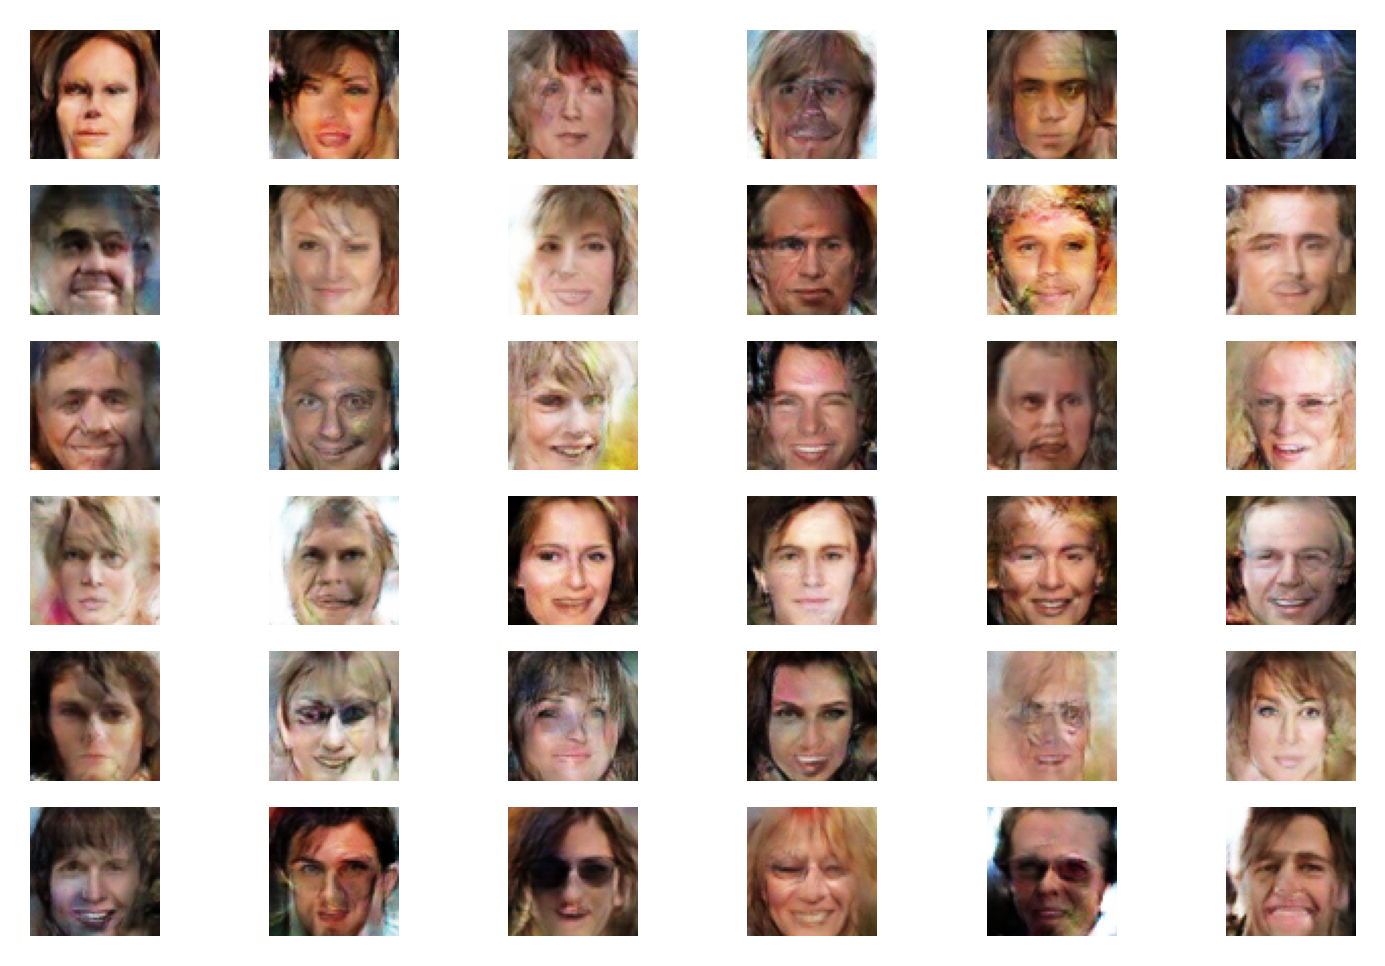

In [60]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input
 
# create a plot of generated images
def plot_generated(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :])
    plt.show()
    plt.savefig('generated_faces.png')
    plt.close()

# load model
model = load_model('generator_model_060.h5')
latent_points = generate_latent_points(60, 60)
savez_compressed('latent_points.npz', latent_points)
X  = model.predict(latent_points)
plot_generated(X, 6)

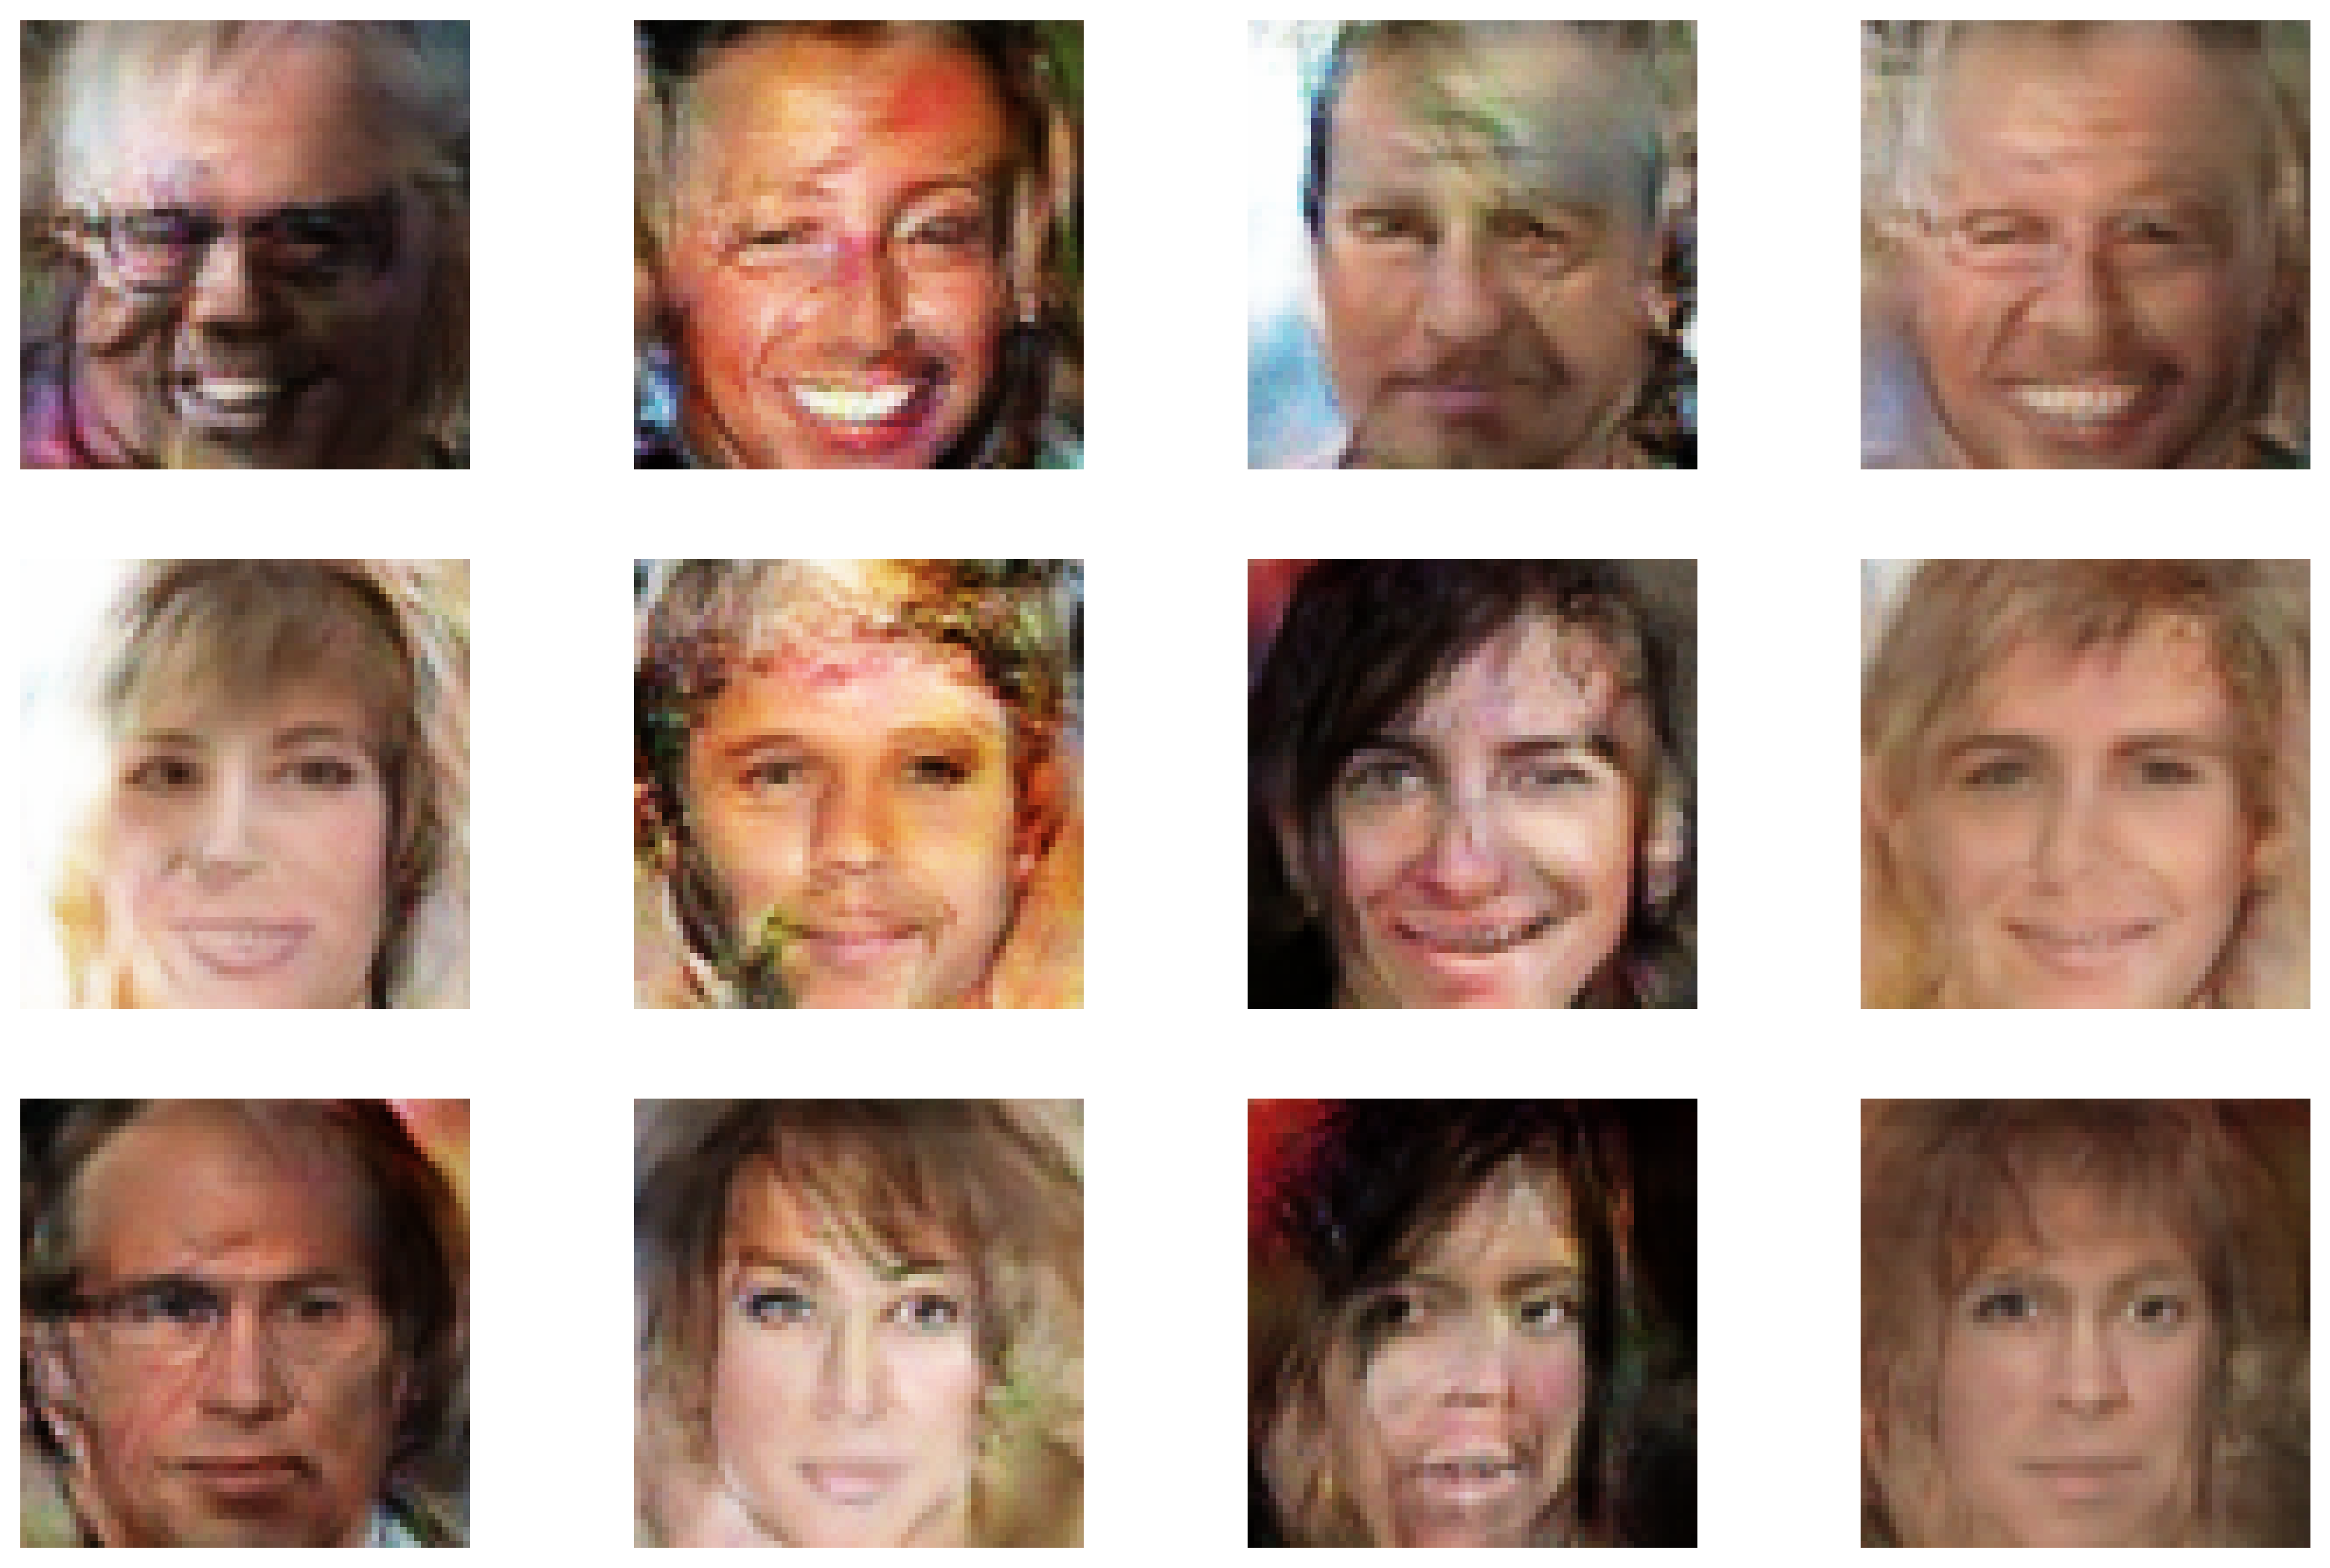

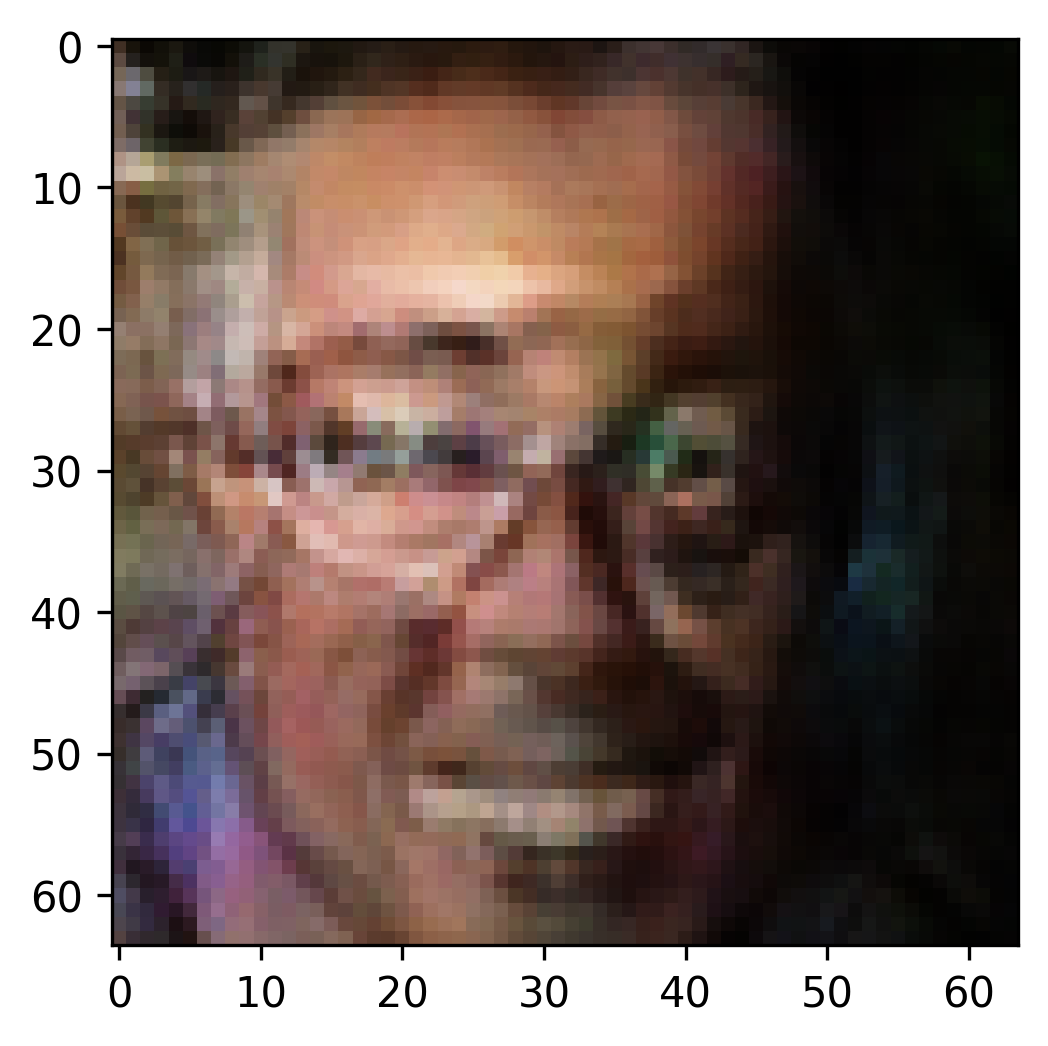

In [61]:
def average_points(points, ix):
    _ix = [i-1 for i in ix]
    vec = points[_ix]
    avg_vec = mean(vec, axis=0)
    vectors = vstack((vec, avg_vec))
    return vectors

def plot_generated(samples, rows, cols):
    plt.figure(figsize=(15,10))
    for i in range(rows * cols):
        plt.subplot(rows, cols, 1 + i)
        plt.axis('off')
        plt.imshow(samples[i, :, :])
    plt.show()

model = load_model('/content/generator_model_060.h5')

smiling_woman_ix = [9, 15, 34]
neutral_woman_ix = [5, 25, 30]
neutral_man_ix = [10, 12, 35]
data = load('latent_points.npz')
points = data['arr_0']

smiling_woman = average_points(points, smiling_woman_ix)
neutral_woman = average_points(points, neutral_woman_ix)
neutral_man = average_points(points, neutral_man_ix)

all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))
images = model.predict(all_vectors)

plot_generated(images, 3, 4)
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
plt.imshow(result_image[0])
plt.show()

## Age prediction
We used a pretrained model to predict age from the image. The age net model is imported and it's existing weights are imported to predict the age of person generated by our generator model.
below we can see that the model predictions are attached both of these images are generated by our generator model and pretrained age detector model predicted the ages of those persons.

In [ ]:
import cv2
import dlib
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread('/content/new_face.png')
image = cv2.resize(image, (720, 640))
frame = image.copy()
  
weights = "Models/age_deploy.prototxt"
config = "Models/age_net.caffemodel"
age_Net = cv2.dnn.readNet(config, weights)

ageList = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
           '(25-32)', '(38-43)', '(48-53)', '(60-100)']
model_mean = (78.4263377603, 87.7689143744, 114.895847746)

fH = image.shape[0]
fW = image.shape[1]
Boxes = []
mssg = 'Face Detected' 

face_detector = dlib.get_frontal_face_detector()
img_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = face_detector(img_gray)

if not faces:
    mssg = 'No face detected'
    cv2.putText(img, f'{mssg}', (40, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,255), 2)
    cv2.imshow('Age detected', img)
    cv2.waitKey(0)
    
else:
    for face in faces:
        x = face.left()
        y = face.top()
        x2 = face.right()
        y2 = face.bottom()
  
        box = [x, y, x2, y2]
        Boxes.append(box)
        cv2.rectangle(frame, (x, y), (x2, y2), 
                      (0, 0, 255), 2)
  
    for box in Boxes:
        face = frame[box[1]:box[3], box[0]:box[2]]
  
        blob = cv2.dnn.blobFromImage(
            face, 1.0, (227, 227), model_mean, swapRB=False)
  
        age_Net.setInput(blob)
        age_preds = age_Net.forward()
        age = ageList[age_preds[0].argmax()]
  
        cv2.putText(frame, f'{mssg}:{age}', (box[0],
                                             box[1] - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (0, 0, 255), 2, cv2.LINE_AA)
  
        cv2_imshow(frame)
        cv2.waitKey(0)

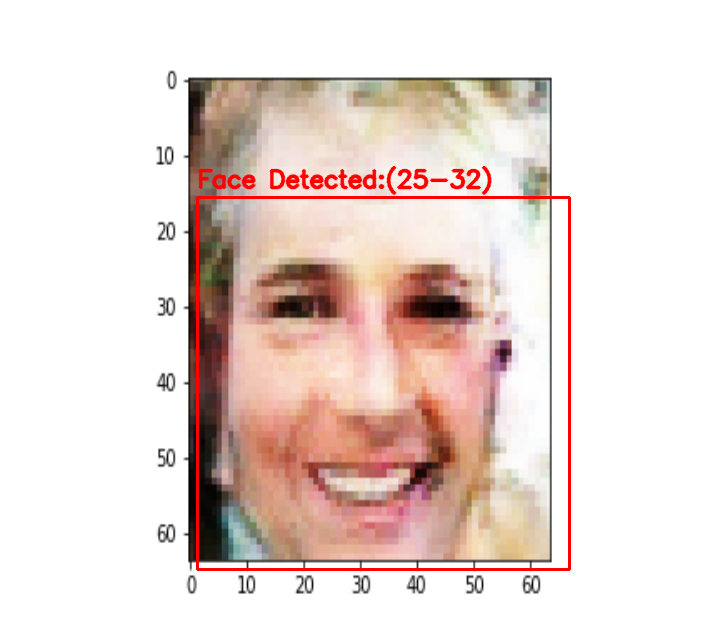
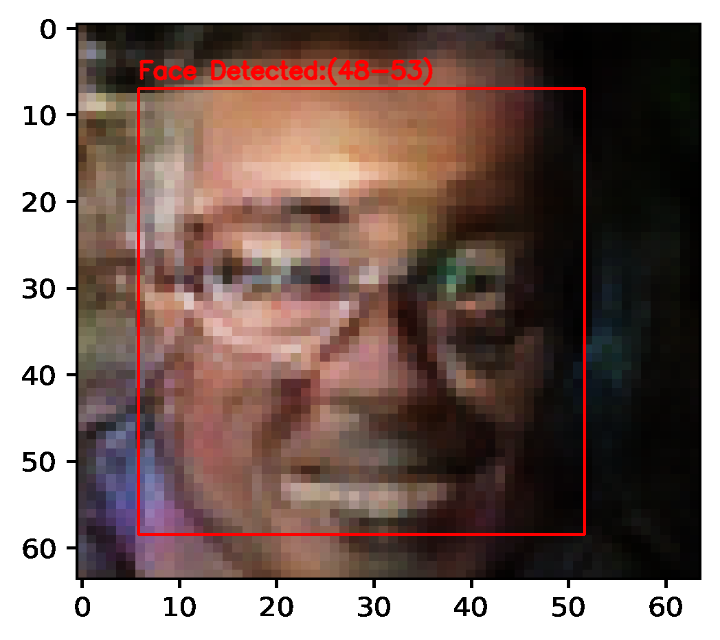